# Ch.8 Introduction to deep learning for computer vision

**Chapter contents**:

* 컨벌루션 신경망(convnet) 이해
* 데이터 증강(augmentation)을 사용하여 과적합 완화
* 사전 훈련된 convnet을 사용하여 특징 추출(feature extraction) 수행
* 사전 훈련된 convnet 미세 조정(fine-tuning)

<br>

* **컴퓨터 비전**은 딥 러닝의 가장 초기의 가장 큰 성공 사례입니다.
* 2011년에서 2015년 사이에 딥 러닝의 초기 부상으로 이어짐

## Introduction to convnets

**Instantiating a small convnet**

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         7385

**Training the convnet on MNIST images**

In [9]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))    # for Conv2D operation with multiple channels
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))      # for Conv2D operation with multiple channels
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 6s 7ms/step - loss: 0.0141 - accuracy: 0.9959
Epoch 2/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0112 - accuracy: 0.9968
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0088 - accuracy: 0.9973
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0078 - accuracy: 0.9976
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0066 - accuracy: 0.9979


**Evaluating the convnet**

In [11]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0337 - accuracy: 0.9925
Test accuracy: 0.993


### The convolution operation

* **Dense** layers : 입력 특징 공간에서 **전역** 패턴 학습
* **Convolution** layers : **로컬** 패턴 학습

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-01.png" width="150"><p style="text-align:center">Figure 8.1 Images can be broken into local patterns such as edges, textures, and so on.</p>

* 그들이 배우는 패턴은 **이동 불변성(translation-invariant)**입니다.
* 패턴의 **공간 계층 구조(spatial hierarchies)**를 배울 수 있습니다.

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-02.png" width="300"><p style="text-align:center">Figure 8.2 The visual world forms a spatial hierarchy of visual modules: elementary lines or textures combine into simple objects such as eyes or ears, which combine into high-level concepts such as “cat.”</p>


**2D-컨볼루션**은 특징 맵이라고 하는 **rank-3 텐서**에서 작동합니다.

컨볼루션 연산은 입력 특징 맵에서 패치를 추출하고 이러한 모든 패치에 동일한 변환을 적용하여 출력 특징 맵을 생성합니다.

**MNIST 1st Conv Layer** : 입력 28,28,1 $\rightarrow$ 32 필터 $\rightarrow$ 출력 26,26,32

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-03.png" width="350"><p style="text-align:center">Figure 8.3 The concept of a response map: a 2D map of the presence of a pattern at different locations in an input</p>

**Convolutions paramaters:** 

* `kernel_size`: size of patch extracted from the inputs e.g. 3x3 `(window_height, window_width)`
* `filters`: depth of the output feature map `(output_depth)`

**`Conv2D(output_depth, (window_height, window_width))`**

컨볼루션은 3D 입력 특징 맵 위로 창을 슬라이드하고, 패치를 추출하고, 변환을 적용하고, 1D 벡터 `(output_depth, )` 를 출력합니다.

모든 패치에서 동일한 커널이 재사용됩니다.

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-04.png" width="350"><p style="text-align:center">Figure 8.4 How convolution works</p>

출력 너비와 높이는 입력과 다를 수 있습니다:

* padding 에 따른 테두리 효과
* strides (보폭)

#### Understanding border effects and padding

* 5 x 5 with 3 x 3 window $\rightarrow$ 3 x 3 grid
* 28 x 28 with 3 x 3 window $\rightarrow$  26 x 26 grid

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-05.png" width="350"><p style="text-align:center">Figure 8.5 Valid locations of 3×3 patches in a 5×5 input feature map</p>

**Padding**
`valid` or `same`
<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-06.png" width="400"><p style="text-align:center">Figure 8.6 Padding a 5×5 input in order to be able to extract 25 3×3 patches</p>

#### Understanding convolution strides

3 x 3 with stride 2

* stride 2 는 입력 특징 맵을 2배로 다운샘플링합니다.
* 분류 모델에서 자주 사용되지 않음

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-07.png" width="400"><p style="text-align:center">Figure 8.7 3 × 3 convolution patches with 2 × 2 strides</p>


### The max-pooling operation

MaxPooling2D의 역할: 특징 맵을 공격적으로 다운샘플링(strided convolution 처럼)

각 특징 맵에 대한 패치의 최대값(maximum value) 유지

일반적으로: stride가 2인 2 x 2 window

**An incorrectly structured convnet missing its max-pooling layers**

In [12]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model_no_max_pool.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 61952)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

In [14]:
model_no_max_pool.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model_no_max_pool.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 8s 8ms/step - loss: 0.1118 - accuracy: 0.9660
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0420 - accuracy: 0.9875
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0309 - accuracy: 0.9909
Epoch 4/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0251 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0206 - accuracy: 0.9937


In [15]:
test_loss, test_acc = model_no_max_pool.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0286 - accuracy: 0.9909
Test accuracy: 0.991


뭐가 잘못 되었나?:

* 특징의 공간적 계층 구조를 학습하지 않음 ( 3번째 3x3 conv 는 초기 입력의 7x7을 "본다"). 높은 수준의 정보가 충분하지 않음
* 너무 큰 특징 맵 (50만 개 이상의 매개변수) -> 과적합


이것이 우리가 max pooling을 사용하는 이유입니다.

다른 다운샘플링 방법:

* strides 2
* avg pooling

Max pooling: 분류에 더 적합

## Training a convnet from scratch on a small dataset

Classify dogs and cats

* 5,000 pictures
* 2,500 dogs, 2,500 cats
* 2,000 training, 1,000 validation, 2,000 testing

**Steps**:
1. 정규화 없이 처음부터 훈련(~70% acc)
2. 데이터 증강 도입(~80-85% acc)
3. 사전 훈련된 모델에서 특징 추출(feature extraction)(~97.5% acc)
4. 사전 훈련된 모델 미세 조정(fine-tune)(~98.5% acc)

### The relevance of deep learning for small-data problems

### Downloading the data

In [23]:
#from google.colab import files
#files.upload()

/c/Users/User/Notebooks


In [27]:
# go to kaggle.com and login
# Your Profile ==> Account ==> API ==> click "Create New API Token"
!mkdir ..\.kaggle
!cp ..\Downloads\kaggle.json ..\.kaggle
#!chmod 600 ../.kaggle/kaggle.json

In [29]:
#!kaggle datasets list -s 'dogs-vs-cats'

In [30]:
# WARNING
# You have to go to https://www.kaggle.com/c/dogs-vs-cats/rules
# and Click the "I Understand and Accept" button.
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
!unzip dogs-vs-cats.zip
!unzip -qq train.zip

^C
^C


**Copying images to training, validation, and test directories**

In [34]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train",      start_index=0,    end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test",       start_index=1500, end_index=2500)

In [37]:
data_dir = 'cats_vs_dogs_small'
!ls $data_dir
!ls $data_dir/train
!ls $data_dir/train/cat | wc -l

test
train
validation
cat
dog
1000


<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-08.png" width="500"><p style="text-align:center">Figure 8.8 Samples from the Dogs vs. Cats dataset. Sizes weren’t modified: the samples come in different sizes, colors, backgrounds, etc.</p>

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [38]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [39]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

**Configuring the model for training**

In [41]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

Steps:

1. 사진 파일 읽기
2. JPEG를 픽셀의 RGB 그리드로 디코딩
3. 부동 소수점 텐서로 변환
4. 180x180으로 크기 조정
5. 배치(batches)로 포장

**Using `image_dataset_from_directory` to read images**

In [42]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


`tf.data.Dataset`은 (for 루프에서 사용하는) 반복자(iterator)입니다.

비동기 데이터 프리페치(prefetching)를 처리할 수 있습니다.

In [43]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [49]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [50]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [51]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [52]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [53]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 5s 60ms/step - loss: 0.7211 - accuracy: 0.4945 - val_loss: 0.6928 - val_accuracy: 0.5130
Epoch 2/30
63/63 [==============================] - 3s 45ms/step - loss: 0.7030 - accuracy: 0.5175 - val_loss: 0.6736 - val_accuracy: 0.5910
Epoch 3/30
63/63 [==============================] - 3s 44ms/step - loss: 0.6828 - accuracy: 0.5880 - val_loss: 0.6850 - val_accuracy: 0.5490
Epoch 4/30
63/63 [==============================] - 3s 45ms/step - loss: 0.6473 - accuracy: 0.6355 - val_loss: 0.6538 - val_accuracy: 0.6060
Epoch 5/30
63/63 [==============================] - 3s 46ms/step - loss: 0.6121 - accuracy: 0.6600 - val_loss: 0.6377 - val_accuracy: 0.6470
Epoch 6/30
63/63 [==============================] - 3s 44ms/step - loss: 0.5807 - accuracy: 0.7135 - val_loss: 1.1574 - val_accuracy: 0.5420
Epoch 7/30
63/63 [==============================] - 3s 46ms/step - loss: 0.5338 - accuracy: 0.7425 - val_loss: 0.5634 - val_accuracy: 0.7130
Epoch 8/30
63

**Displaying curves of loss and accuracy during training**

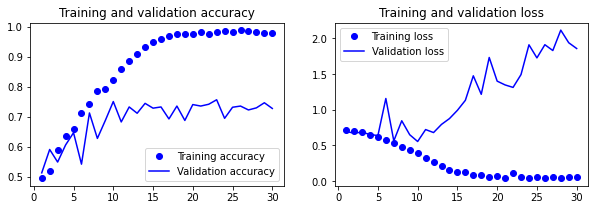

In [54]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-09.png" width="500"><p style="text-align:center">Figure 8.9 Training and validation metrics for a simple convnet</p>

**Evaluating the model on the test set**

In [55]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 24ms/step - loss: 0.5717 - accuracy: 0.7515
Test accuracy: 0.752


Current accuracy: ~70%

Main problem: overfitting

Already learned: drop out, L2 regularization

Another solution: data augmentation(80-85%)

### Using data augmentation

**Define a data augmentation stage to add to an image model**

**Data augmentation**

무작위 변환(예: 뒤집기, 회전, 크기 조정 등)을 적용하여 기존 데이터에서 "새" 데이터 생성

다양한 방법이 있음.

여기서 우리는 data augmentation layers와 함께 Sequential 모델을 사용할 것입니다.


In [56]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

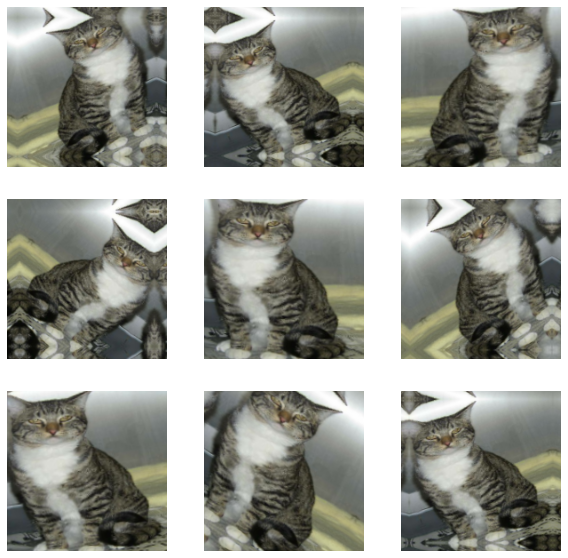

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [58]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [59]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 4s 49ms/step - loss: 0.7268 - accuracy: 0.5175 - val_loss: 0.6903 - val_accuracy: 0.5020
Epoch 2/100
63/63 [==============================] - 3s 47ms/step - loss: 0.6991 - accuracy: 0.5535 - val_loss: 0.6690 - val_accuracy: 0.5760
Epoch 3/100
63/63 [==============================] - 3s 46ms/step - loss: 0.6812 - accuracy: 0.5755 - val_loss: 0.6746 - val_accuracy: 0.5710
Epoch 4/100
63/63 [==============================] - 3s 48ms/step - loss: 0.6604 - accuracy: 0.6100 - val_loss: 0.6562 - val_accuracy: 0.5990
Epoch 5/100
63/63 [==============================] - 3s 46ms/step - loss: 0.6536 - accuracy: 0.6285 - val_loss: 0.6424 - val_accuracy: 0.6510
Epoch 6/100
63/63 [==============================] - 3s 45ms/step - loss: 0.6415 - accuracy: 0.6535 - val_loss: 0.9569 - val_accuracy: 0.5800
Epoch 7/100
63/63 [==============================] - 3s 46ms/step - loss: 0.6170 - accuracy: 0.6860 - val_loss: 0.6202 - val_accuracy: 0.6590
Epoch 

63/63 [==============================] - 3s 46ms/step - loss: 0.2392 - accuracy: 0.9025 - val_loss: 0.5862 - val_accuracy: 0.8280
Epoch 59/100
63/63 [==============================] - 3s 46ms/step - loss: 0.2347 - accuracy: 0.9010 - val_loss: 0.5035 - val_accuracy: 0.8440
Epoch 60/100
63/63 [==============================] - 3s 46ms/step - loss: 0.2389 - accuracy: 0.9080 - val_loss: 1.2348 - val_accuracy: 0.7750
Epoch 61/100
63/63 [==============================] - 3s 46ms/step - loss: 0.2277 - accuracy: 0.9070 - val_loss: 0.5729 - val_accuracy: 0.8380
Epoch 62/100
63/63 [==============================] - 3s 47ms/step - loss: 0.2037 - accuracy: 0.9185 - val_loss: 1.4075 - val_accuracy: 0.7540
Epoch 63/100
63/63 [==============================] - 3s 49ms/step - loss: 0.2528 - accuracy: 0.9145 - val_loss: 0.3704 - val_accuracy: 0.8630
Epoch 64/100
63/63 [==============================] - 3s 47ms/step - loss: 0.2097 - accuracy: 0.9090 - val_loss: 0.8560 - val_accuracy: 0.7690
Epoch 65/100

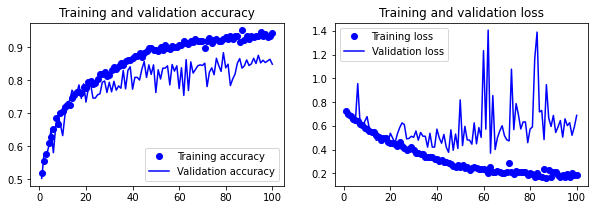

In [60]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1,2,2)
#plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-11.png" width="500"><p style="text-align:center">Figure 8.11 Training and validation metrics with data augmentation</p>

**Evaluating the model on the test set**

In [61]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 21ms/step - loss: 0.4403 - accuracy: 0.8500
Test accuracy: 0.850


## Leveraging a pretrained model

작은 데이터 세트만을 사용할 수 있는 경우의 일반적인 관행:

훨씬 더 큰 데이터 세트로 유사한 작업에 대해 이미 훈련된 모델을 사용합니다.

이미지의 예: ImageNet 데이터 세트(140만 이미지, 1K 클래스)

사전 훈련된 모델을 사용하는 2가지 방법:

* **특징 추출 (feature extraction)**
* **미세 조정 (fine-tuning)**


### Feature extraction with a pretrained model

이전에 훈련된 모델에서 학습한 표현(representations)을 사용하여 새 샘플에서 흥미로운 특증을 추출

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-12.png" width="500"><p style="text-align:center">Figure 8.12 Swapping classifiers while keeping the same convolutional base</p>

**Instantiating the VGG16 convolutional base**

In [62]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [63]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**두 가지 접근 방식**

* 데이터 세트에 대해 `conv_base`를 실행하고, 출력을 numpy 배열로 디스크에 저장합니다. 그런 다음 이에 대해 분류기를 훈련시킵니다. (더 빠름)

* 상단에 Dense 레이어를 추가하여 `conv_base`를 확장합니다. 데이터 증대를 사용하여 전체 모델을 실행합니다. (더 느림)


#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [64]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features,   val_labels   =  get_features_and_labels(validation_dataset)
test_features,  test_labels  =  get_features_and_labels(test_dataset)

In [73]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [66]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 13ms/step - loss: 17.0261 - accuracy: 0.9290 - val_loss: 25.4709 - val_accuracy: 0.8530
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.1024 - accuracy: 0.9720 - val_loss: 5.7145 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.4761 - accuracy: 0.9815 - val_loss: 7.4932 - val_accuracy: 0.9620
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2300 - accuracy: 0.9870 - val_loss: 6.0330 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 1.0466 - accuracy: 0.9920 - val_loss: 5.4220 - val_accuracy: 0.9690
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6821 - accuracy: 0.9925 - val_loss: 6.5356 - val_accuracy: 0.9690
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.5291 - accuracy: 0.9950 - val_loss: 4.3488 - val_accuracy: 0.9790
Epoch 8/20
63/63 

**Plotting the results**

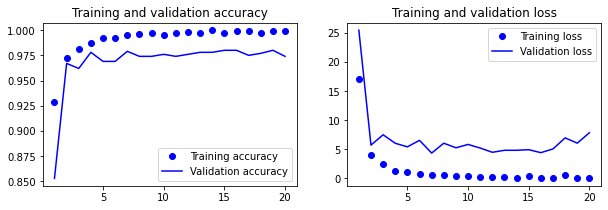

In [67]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1,2,2)
#plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-13.png" width="500"><p style="text-align:center">Figure 8.13 Training and validation metrics for plain feature extraction</p>

**acc ~97%**

**Very good, but with overfitting.**


#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [68]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [69]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [70]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [71]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [72]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 115ms/step - loss: 20.4021 - accuracy: 0.9055 - val_loss: 4.9586 - val_accuracy: 0.9740
Epoch 2/50
63/63 [==============================] - 7s 108ms/step - loss: 7.6885 - accuracy: 0.9460 - val_loss: 4.0430 - val_accuracy: 0.9730
Epoch 3/50
63/63 [==============================] - 7s 110ms/step - loss: 5.0373 - accuracy: 0.9625 - val_loss: 5.5084 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 7s 108ms/step - loss: 6.5922 - accuracy: 0.9535 - val_loss: 4.6087 - val_accuracy: 0.9700
Epoch 5/50
63/63 [==============================] - 7s 104ms/step - loss: 3.4455 - accuracy: 0.9625 - val_loss: 3.6314 - val_accuracy: 0.9770
Epoch 6/50
63/63 [==============================] - 6s 102ms/step - loss: 4.0866 - accuracy: 0.9655 - val_loss: 4.3071 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 6s 103ms/step - loss: 3.4052 - accuracy: 0.9700 - val_loss: 4.5081 - val_accuracy: 0.9760
Epoch

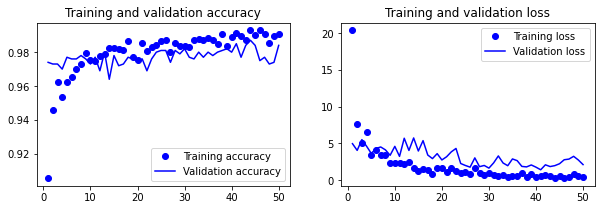

In [74]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1,2,2)
#plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-14.png" width="500"><p style="text-align:center">Figure 8.14 Training and validation metrics for feature extraction with data augmentation</p>

**Evaluating the model on the test set**

In [75]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 67ms/step - loss: 2.2583 - accuracy: 0.9755
Test accuracy: 0.975


### Fine-tuning a pretrained model

1. 이미 훈련된 기본 네트워크 위에 맞춤형 네트워크를 추가합니다. (완료)
2. 기본 네트워크를 고정합니다. (완료)
3. 우리가 추가한 부분을 훈련시킵니다. (완료)
4. 기본 네트워크의 **일부 레이어를 고정 해제**합니다.
5. 이 레이어와 우리가 추가한 부분을 함께 훈련합니다.

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-15.png" width="200"><p style="text-align:center">Figure 8.15 Fine-tuning the last convolutional block of the VGG16 network</p>

In [76]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [77]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [78]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 9s 117ms/step - loss: 0.3640 - accuracy: 0.9930 - val_loss: 2.0275 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 7s 114ms/step - loss: 0.4724 - accuracy: 0.9880 - val_loss: 1.8698 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - 7s 112ms/step - loss: 0.4386 - accuracy: 0.9875 - val_loss: 2.2819 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 7s 114ms/step - loss: 0.1588 - accuracy: 0.9920 - val_loss: 2.1370 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 7s 117ms/step - loss: 0.2521 - accuracy: 0.9925 - val_loss: 1.7280 - val_accuracy: 0.9840
Epoch 6/30
63/63 [==============================] - 7s 116ms/step - loss: 0.1055 - accuracy: 0.9950 - val_loss: 1.7344 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 7s 112ms/step - loss: 0.1814 - accuracy: 0.9955 - val_loss: 2.0350 - val_accuracy: 0.9810
Epoch 

In [79]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 66ms/step - loss: 1.5880 - accuracy: 0.9760
Test accuracy: 0.976


## Summary

* Convnet은 현재 CV 작업에 가장 적합한 유형의 ML 모델입니다. 작은 datsaset에서 처음부터 훈련하고 적절한 성능을 얻을 수 있습니다.
* Convnet은 시각적 세계를 표현하기 위해 모듈식 패턴과 개념의 계층 구조를 학습합니다.
* 과적합 시 유용한 데이터 증강(augmentation)
* 사전 훈련된 convnet을 재사용하는 것은 쉽습니다.
   * 특징 추출 (feature extraction)
   * 미세 조정 (fine-tuning)